In [2319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./data/Linear Accelerometer.csv")

# Suodatetaan ensimmäiset 20 sekuntia pois
df = df[df['Time (s)'] > 20]
df = df.reset_index(drop=True)

# Asetetaan aika alkamaan nollasta
df['Time (s)'] = df['Time (s)'] - df['Time (s)'].min()

df.head()

,Time (s),X (m/s^2),Y (m/s^2),Z (m/s^2)
0,0.000000,-0.660490,-0.895177,4.881056
1,0.009991,-0.187386,-0.254945,4.902012
2,0.019982,0.582261,0.228981,4.163439
3,0.029973,1.620251,0.341770,3.505075
4,0.039965,2.007720,0.217309,3.356325


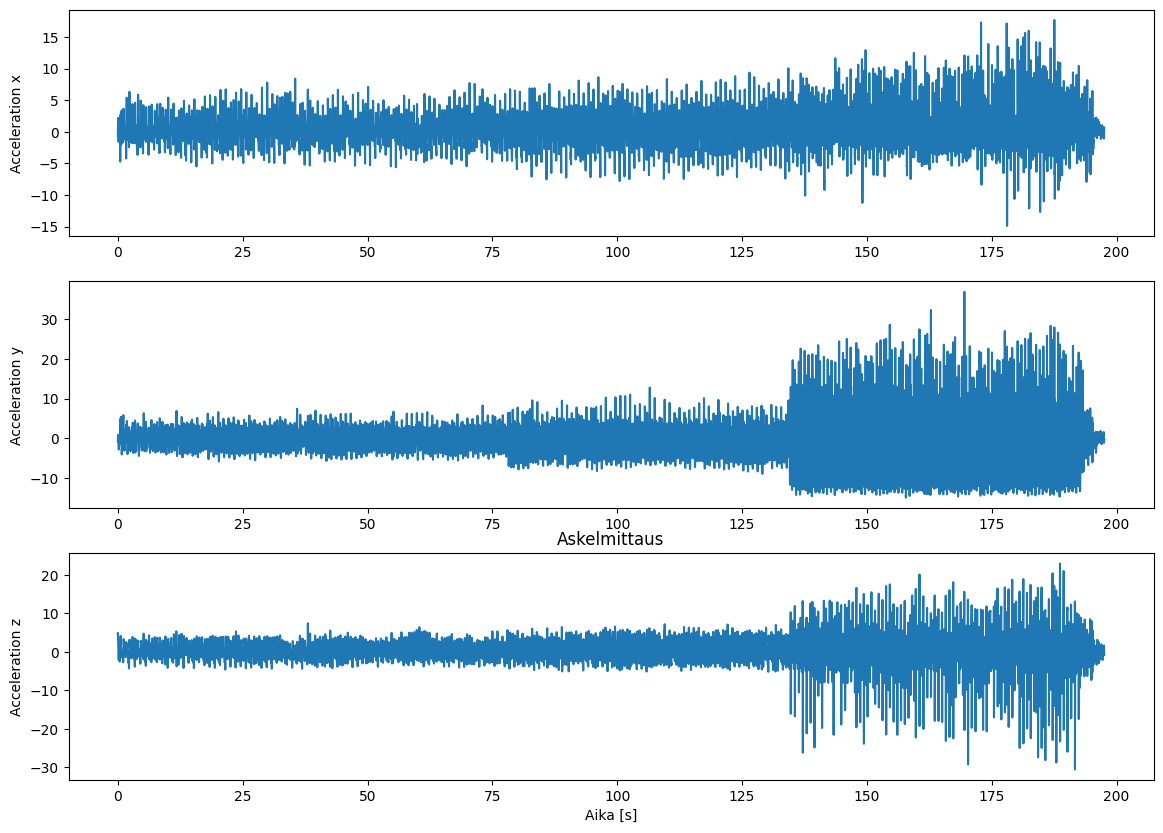

In [2320]:
plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(df['Time (s)'],df['X (m/s^2)'])
plt.ylabel('Acceleration x')
plt.subplot(3,1,2)
plt.plot(df['Time (s)'],df['Y (m/s^2)'])
plt.ylabel('Acceleration y')
plt.subplot(3,1,3)
plt.plot(df['Time (s)'],df['Z (m/s^2)'])
plt.ylabel('Acceleration z')
plt.title('Askelmittaus')
plt.xlabel('Aika [s]')
plt.show()

# Y-komponentti näyttäisi parhaiten kuvaavan askelmittausta

In [2321]:
#Tuodaan filtterifunktiot. Jos scipy puuttuu: pip install scipy
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff,  nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

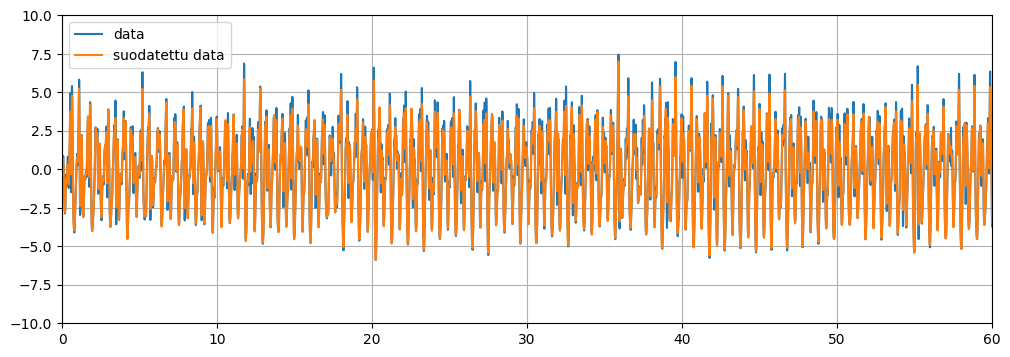

Askelten määrä on 578.0


In [2322]:
#Data suodatetaan alipäästösuodattimella, joka poistaa siitä valittua cut-off -taajuutta suuremmilla
#taajuuksilla tapahtuvat vaihtelut.
#Käytännössä dataa "tasoitetaan", eli alipäästösuodatin vastaa jossain määrin liukuvaa keskiarvoa. 
data = df['Y (m/s^2)']
T_tot = df['Time (s)'].max() #Koko datan pituus
n = len(df['Time (s)']) #Datapisteiden lukumäärä
fs = n/T_tot #Näytteenottotaajus, OLETETAAN VAKIOKSI
nyq = fs/2 #Nyqvistin taajuus, suurin taajuus, joka datasta voidaan havaita
order = 3
cutoff = 1 / 0.1  #Cut-off taajuus, tätä suuremmat taajuuden alipäästösuodatin poistaa datasta
#Cut-off -taajuuden tulee olla riittävän pieni, jotta data yleensäkin suodattuu
#Cut-off -taajuuden ei tule olla niin pieni, että se suodattaisi pois askelia
data_filt = butter_lowpass_filter(data, cutoff, nyq, order)

#Piirretään kuvaa, jossa alkuperäinen ja suodatettu signaali
plt.figure(figsize=(12,4))
plt.plot(df['Time (s)'],data,label = 'data')
plt.plot(df['Time (s)'],data_filt,label = 'suodatettu data')
plt.axis([0,60,-10,10])
plt.grid()
plt.legend()
plt.show()

#Lasketaan askelet
#Tutkitaan, kuinka usein suodatettu signaali ylittää nollatason
jaksot = 0
for i in range(n-1):
    if data_filt[i]/data_filt[i+1] < 0: #True jos arvoilla data_filt[i] ja data_filt[i+1] on eri etumerkki --> nollan ylitys
        jaksot = jaksot + 1/2

print('Askelten määrä on', jaksot ) #Nolla ylitetään kaksi kertaa jokaista jaksoa kohti

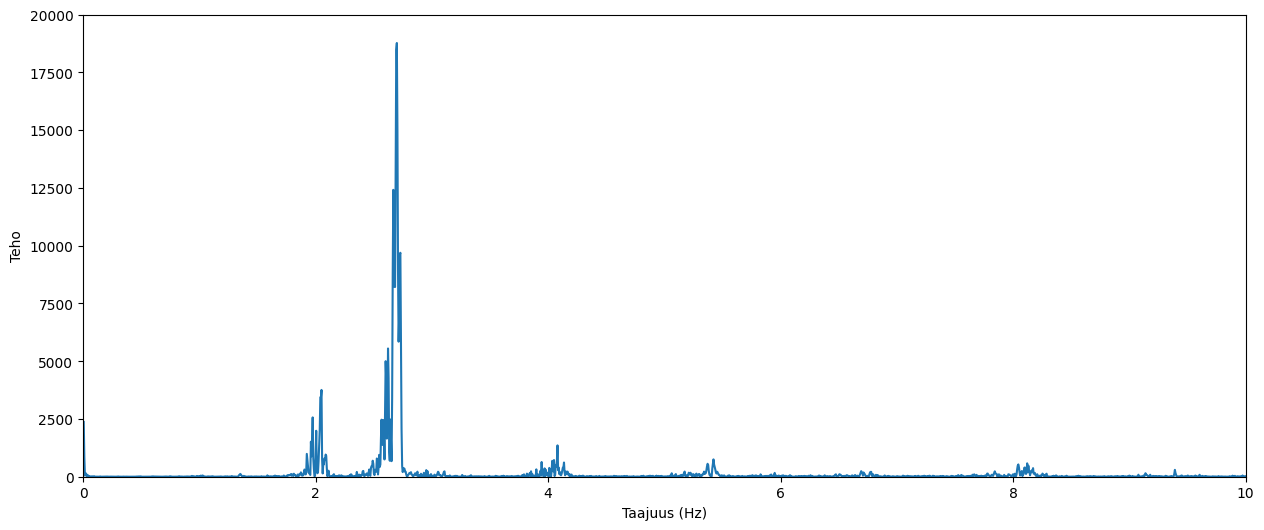

In [2323]:
signal = df['Y (m/s^2)']
t = df['Time (s)'] #aika, alkaa nollasta, sekunteina
N = len(signal) #havaintojen määrä
dt = np.max(t/N) #Näytteenottoväli (oletetaan vakioksi)

#Fourier-analyysi
fourier = np.fft.fft(signal,N) #Fourier muunnos
psd = fourier*np.conj(fourier)/N
freq = np.fft.fftfreq(N, dt) #Taajuudet
L = np.arange(1,int(N/2)) #Negatiivisten ja nollataajuuksien rajaus

plt.figure(figsize=(15,6))
plt.plot(freq[L],psd[L].real)
plt.xlabel('Taajuus (Hz)')
plt.ylabel('Teho')
plt.axis([0,10,0,20000])
plt.show()

In [2324]:
f_max = freq[L][psd[L] == np.max(psd[L])][0] #Kävelymittauksen kiihtyvyyden y-komponentin tehospektrin suurinta tehoa vastaava taajuus
# Eli toisinsanoen askelluksen dominoiva taajuus
T = 1/f_max #Askeleeseen kuluva aika, eli jaksonaika
steps = f_max*np.max(t) #Askelmäärä. Voi laskea myös np.max(t)/T

print('Dominoiva askeltaajuus on', f_max)
print('Tätä vastaava jaksonaika (askelaika) on', T)
print('Askelmäärä tällöin ',steps)

Dominoiva askeltaajuus on 2.698422806275888
Tätä vastaava jaksonaika (askelaika) on 0.37058684712945594
Askelmäärä tällöin  533.0


In [2325]:
#Ladataan karttadata
import pandas as pd
import folium
df = pd.read_csv('./data/Location.csv')

# Suodatetaan ensimmäiset 20 sekuntia pois
df = df[df['Time (s)'] > 20]
df = df.reset_index(drop=True)

# Asetetaan aika alkamaan nollasta
df['Time (s)'] = df['Time (s)'] - df['Time (s)'].min()

df.head()
# a)Piirrä reitti kartalle käyttäen Folium-kirjastoa 

#Rajataan datasta pois ne rivit, joilla horinsontaalinen (epä)tarkkuus on suuri
#df = df[df['Horizontal Accuracy (m)'] <10] #Rajataan pois arvot, joissa df['Horizontal Accuracy (m)'] > 10

# df = df[df['Satellites'] > 30]

#Määritellään "karttapohja", eli kartan keskipiste
lat1 = df['Latitude (°)'].mean() #Latitudin keskiarvo
long1 = df['Longitude (°)'].mean() #Longitudin keskiarvo

#luodaan kartta
my_map = folium.Map(location = [lat1,long1], zoom_start=15)

#Piirretään reitti kartalle:
folium.PolyLine(df[['Latitude (°)','Longitude (°)']], color = 'red', weight = 3).add_to(my_map)
my_map.save('Kartta_15.12.2025.html')

In [2326]:
# d) Laske kuljettu matka käyttäen Haversinen kaavaa.
#Lasketaan matka käyttäen Haversinen kaava
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r



In [2327]:
#Lasketaan kuljettu matka
import numpy as np
df['Distance_calc'] = np.zeros(len(df))

#lasketaan välimatka havaintopisteiden välillä käyttäen For-luuppia
for i in range(len(df)-1):
    lon1 = df['Longitude (°)'][i]
    lon2 = df['Longitude (°)'][i+1]
    lat1 = df['Latitude (°)'][i]
    lat2 = df['Latitude (°)'][i+1]
    df.loc[i+1,'Distance_calc'] = haversine(lon1, lat1, lon2, lat2)

#Lasketaan kokonaismatka mittapisteiden välisestä matkasta
df['total_distance'] = df['Distance_calc'].cumsum()

""" plt.figure(figsize=(12,5))
plt.plot(df['Time (s)'],df['total_distance'])
plt.ylabel('Kokonaismatka [km]')
plt.xlabel('Aika [s]')
plt.title('Laskettu matka ajan funktiona')
plt.grid()
plt.show() """


" plt.figure(figsize=(12,5))\nplt.plot(df['Time (s)'],df['total_distance'])\nplt.ylabel('Kokonaismatka [km]')\nplt.xlabel('Aika [s]')\nplt.title('Laskettu matka ajan funktiona')\nplt.grid()\nplt.show() "

In [2328]:
# Lasketaan keskinopeus ja askelpituus

# Haetaan tarvittavat arvot
kokonaismatka = df['total_distance'].max()  # km
kokonaisaika = df['Time (s)'].max()  # sekuntia
askelmäärä = jaksot  # Laskettu aikaisemmin nollaylitysmenetelmällä

# Keskinopeus
keskinopeus_km_h = (kokonaismatka / kokonaisaika) * 3600  # km/h
keskinopeus_m_s = kokonaismatka * 1000 / kokonaisaika  # m/s

# Askelpituus
askelpituus = (kokonaismatka * 1000) / askelmäärä  # metriä

# Tulostukset
print(f'Kokonaismatka: {kokonaismatka:.3f} km ({kokonaismatka*1000:.1f} m)')
print(f'Kokonaisaika: {kokonaisaika:.1f} s ({kokonaisaika/60:.1f} min)')
print(f'Askelmäärä: {askelmäärä:.0f} askelta')
print()
print(f'Keskinopeus: {keskinopeus_km_h:.2f} km/h ({keskinopeus_m_s:.2f} m/s)')
print(f'Askelpituus: {askelpituus:.2f} m')

Kokonaismatka: 0.361 km (361.2 m)
Kokonaisaika: 197.0 s (3.3 min)
Askelmäärä: 578 askelta

Keskinopeus: 6.60 km/h (1.83 m/s)
Askelpituus: 0.62 m
